# Baseline Model Notebook
### In this notebook, we will go through the process of machine learning model training using the different python libraries.

### Project Definition: Stock Price Movement Prediction

#### Goal:

Develop a supervised machine learning model that predicts whether the closing price of the AAPL stock will increase on the next trading day, based on daily historical market data.

##### Dataset:

A CSV file containing the following columns for each trading day:
- Open (opening price)
- High (highest price)
- Low (lowest price)
- Close (closing price)
- Volume (number of shares traded)

#### Task Specification:
- Target variable: Price_Up_Tomorrow (binary; 1 if Close_tomorrow > Close_today, otherwise 0)
- Features: All columns above, as well as any engineered features you design (e.g., daily return, volatility, moving averages).
- Prediction task:

For each day, use available information to predict whether the closing price on the following day will be higher than the current day’s close.

##### Project Steps:
1.	EDA: Explore and visualize the data, identify trends, missing values, and correlations.
2.	Preprocessing: Handle missing values, scale/normalize features, and create the target variable.
3.	Feature Engineering: Create additional features such as daily returns, volatility, and rolling averages.
4.	Model Training: Split the data into train/test sets; train and evaluate multiple classifiers (e.g., Random Forest, Logistic Regression, XGBoost).
5.	Evaluation: Assess model performance using classification metrics (accuracy, precision, recall, ROC-AUC, confusion matrix).
6.	Explainability: Use feature importance and SHAP values to interpret model predictions.
7.	Discussion: Summarize findings, limitations, and possible next steps.

##### Constraints:
- The model should use only features available at prediction time (no “peeking” into future data).
- The solution must be reproducible and clearly documented.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Data visualization library
import calendar
import pandas_datareader.data as web


from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Data preprocessing libraries
from sklearn.ensemble import RandomForestClassifier # Machine learning libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import mutual_info_regression
import shap # SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model.

import xgboost as xgb # XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
import yfinance as yf # Yahoo Finance is a media property that is part of Yahoo's network, providing financial news, data and commentary including stock quotes, press releases, financial reports, and original content.

### load data

In [2]:
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
df.to_csv("stock_data.csv")

/var/folders/x0/x2vffgpn4mv88fvwb47hvlmc0000gn/T/ipykernel_5923/3440584184.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


### 1. Exploratory Data Analysis (EDA)

In [3]:
# explore the data
df.info()
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1257 non-null   float64
 1   (High, AAPL)    1257 non-null   float64
 2   (Low, AAPL)     1257 non-null   float64
 3   (Open, AAPL)    1257 non-null   float64
 4   (Volume, AAPL)  1257 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1257.000000  1257.000000  1257.000000  1257.000000  1.257000e+03
mean     151.900499   153.427262   150.196282   151.743844  9.061449e+07
std       41.943932    42.082742    41.718434    41.883286  5.325627e+07
min       54.378578    55.379531    51.528412    55.277740  2.323470e+07
25%      126.750748   127.839507   124.727682   126.223139  5.546960e+07

### simple data visualizations

#### Stock prices over time

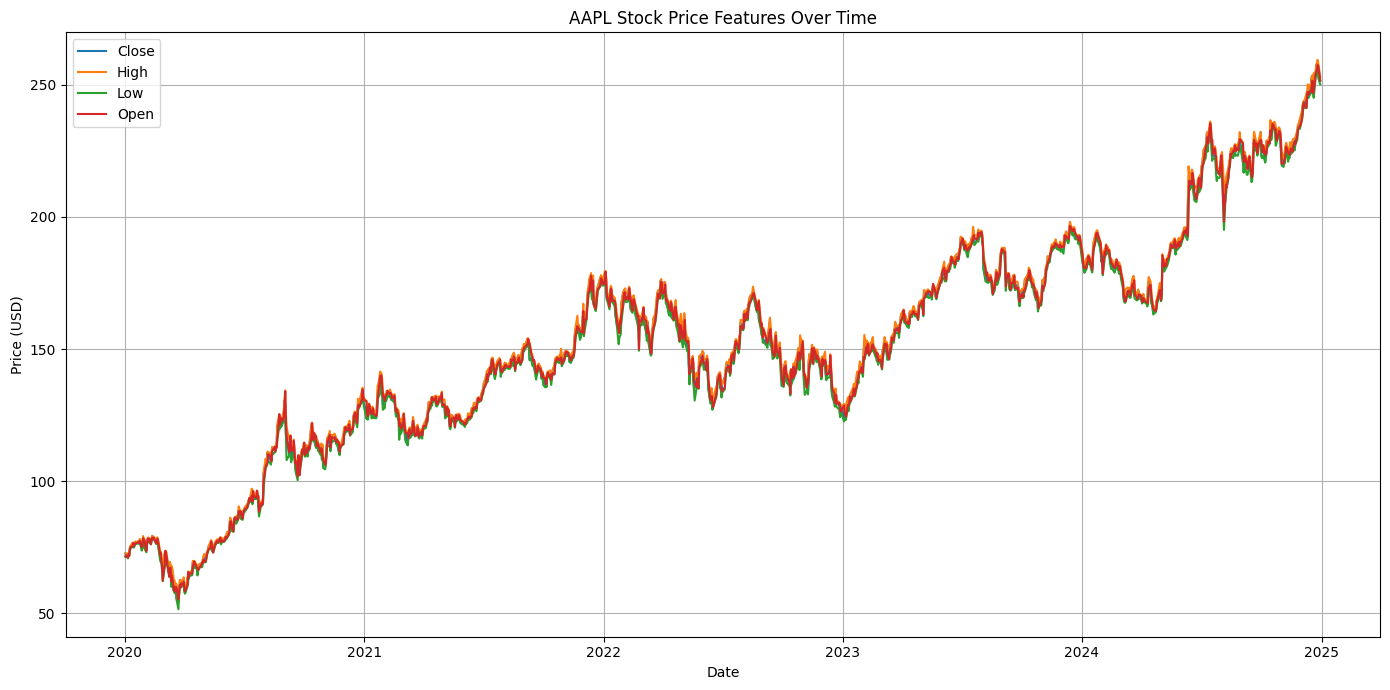

In [4]:
features = ['Close', 'High', 'Low', 'Open']
plt.figure(figsize= (14,7))

for feat in features:
    plt.plot(df.index, df[feat], label=feat)
    plt.plot()

plt.title('AAPL Stock Price Features Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

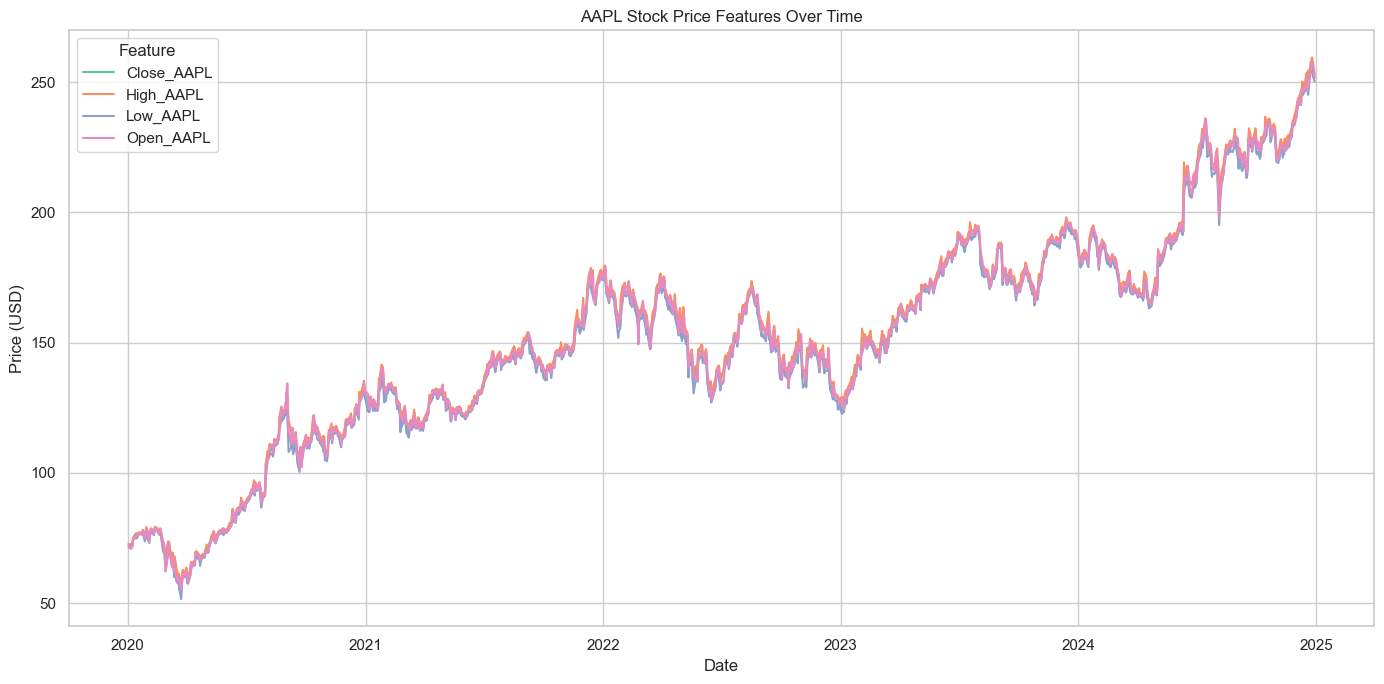

In [5]:
df_for_sns = df.copy()
df_for_sns.columns = ['_'.join(col).strip() for col in df_for_sns.columns.values]

features_for_sns = ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL']

# df long convertion
df_long = df_for_sns[features_for_sns].reset_index().rename(columns={'index': 'Date'}).melt(
    id_vars='Date',
    var_name='Feature',
    value_name='Price'
)

sns.set_theme(style="whitegrid", palette="Set2")

plt.figure(figsize=(14,7))
sns.lineplot(data=df_long, x='Date', y='Price', hue='Feature')

plt.title('AAPL Stock Price Features Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Volume histogram

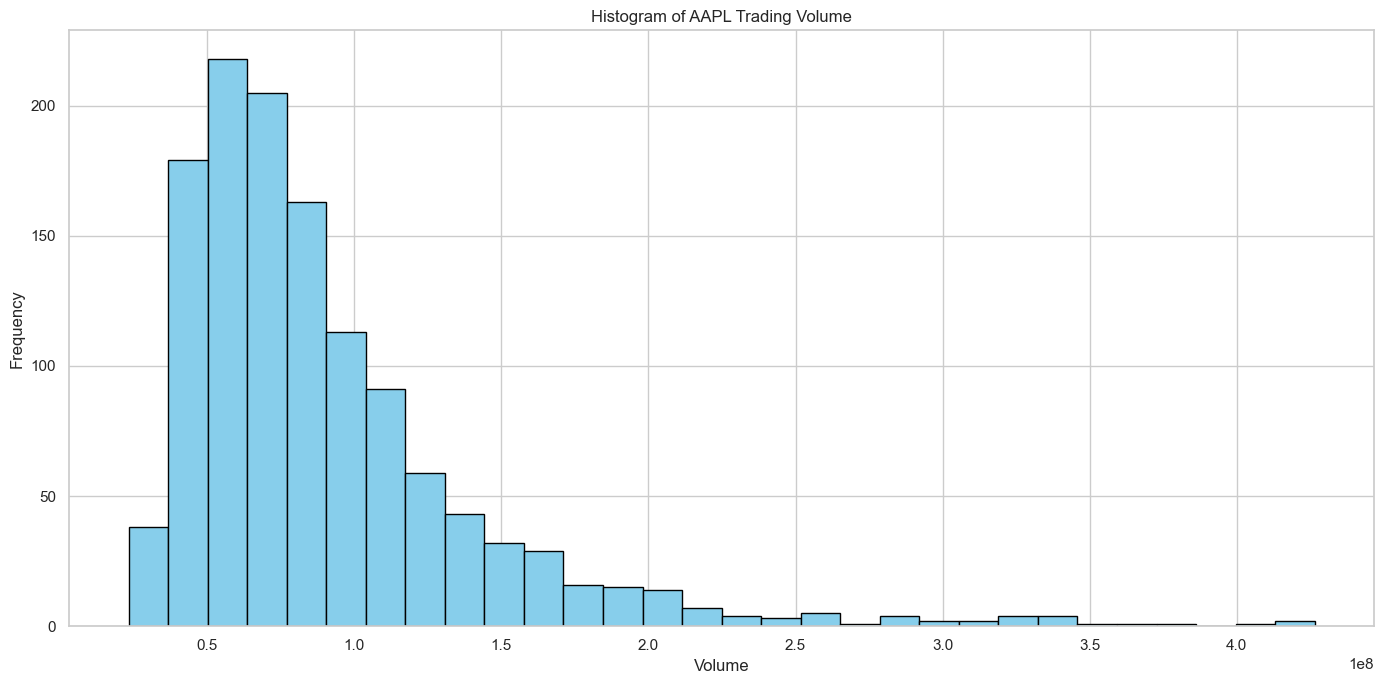

In [6]:
plt.figure(figsize=(14, 7))
plt.hist(df[('Volume', 'AAPL')], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of AAPL Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#### time series of volume

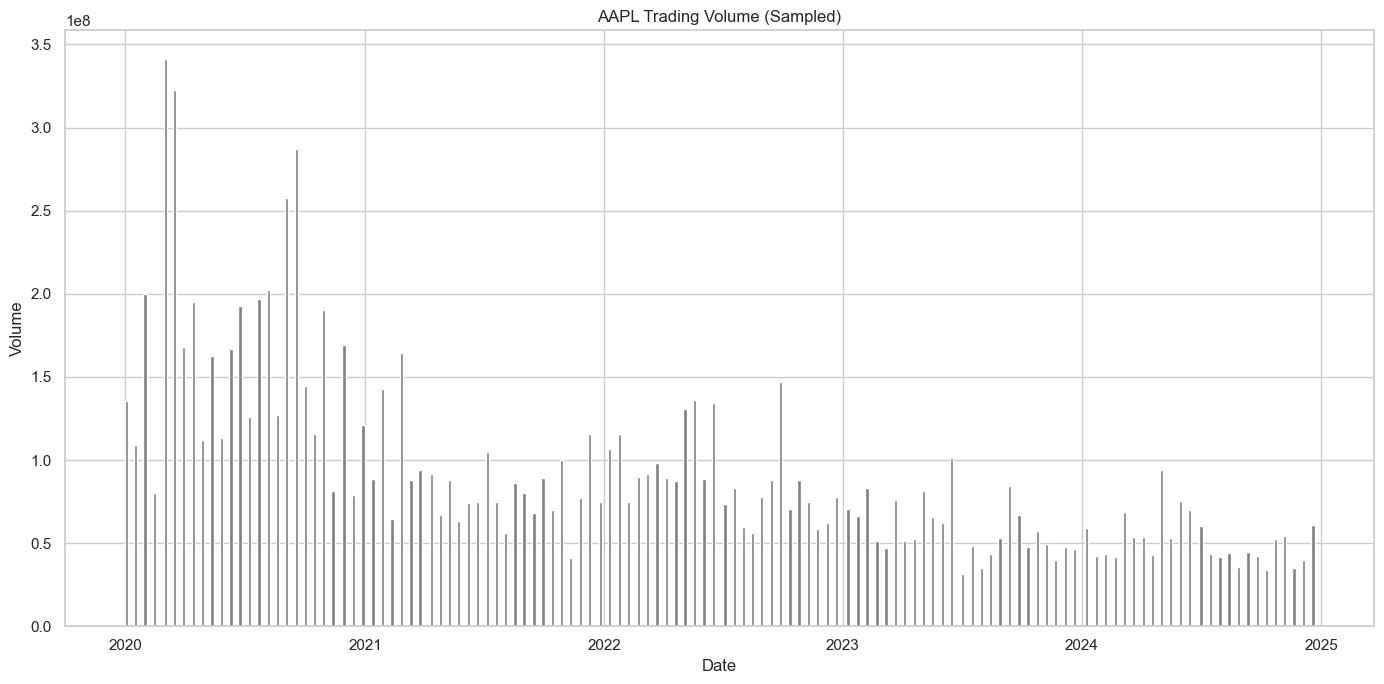

In [7]:
df_downsampled = df[::10]

plt.figure(figsize=(14, 7))
plt.bar(df_downsampled.index, df_downsampled[('Volume', 'AAPL')], width=5, color='gray')
plt.title('AAPL Trading Volume (Sampled)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()


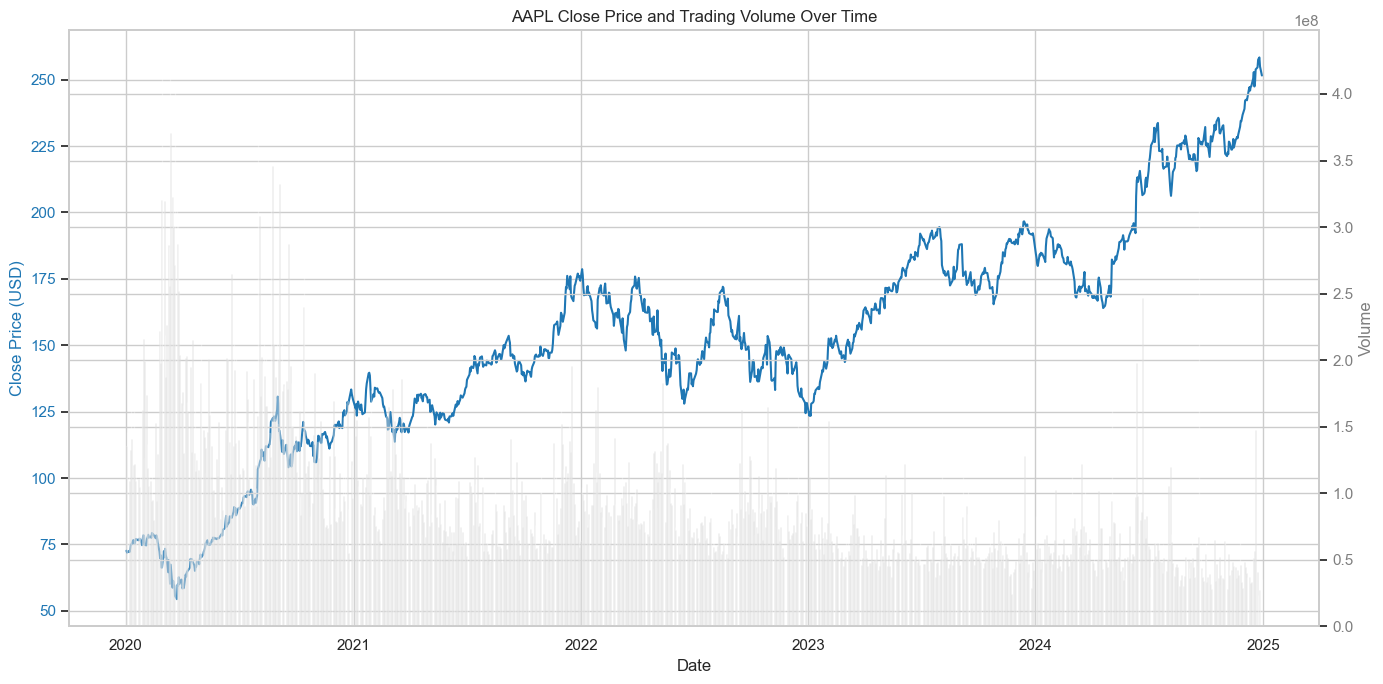

In [8]:
fig, ax1 = plt.subplots(figsize=(14, 7))

color_price = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)', color=color_price)
ax1.plot(df.index, df[('Close', 'AAPL')], color=color_price, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color_price)

ax2 = ax1.twinx()
color_volume = 'tab:gray'
ax2.set_ylabel('Volume', color=color_volume)
ax2.bar(df.index, df[('Volume', 'AAPL')], color=color_volume, alpha=0.3, width=1.0)
ax2.tick_params(axis='y', labelcolor=color_volume)

# כותרת ועיצוב
plt.title('AAPL Close Price and Trading Volume Over Time')
fig.tight_layout()
plt.show()


##### some general examples

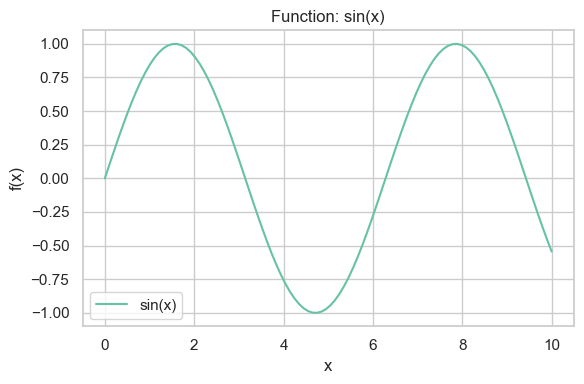

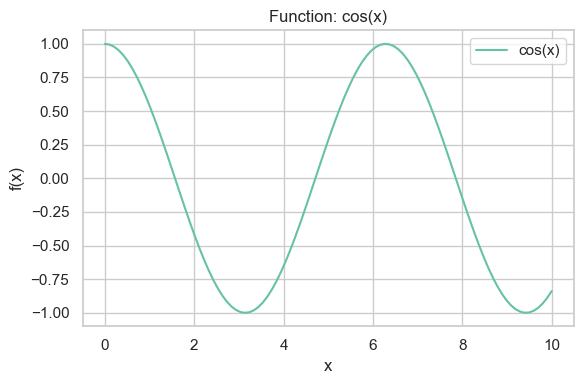

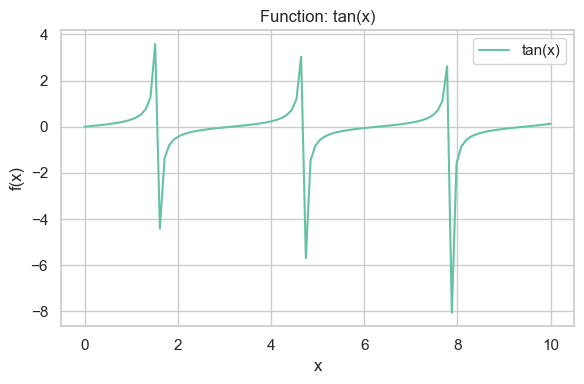

In [9]:
x = np.linspace(0, 10, 100)
functions = {
    'sin(x)': np.sin(x),
    'cos(x)': np.cos(x),
    'tan(x)': np.tan(x) / 5 
}

for name, y in functions.items():
    plt.figure(figsize=(6, 4)) 
    plt.plot(x, y, label=name)
    plt.title(f'Function: {name}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

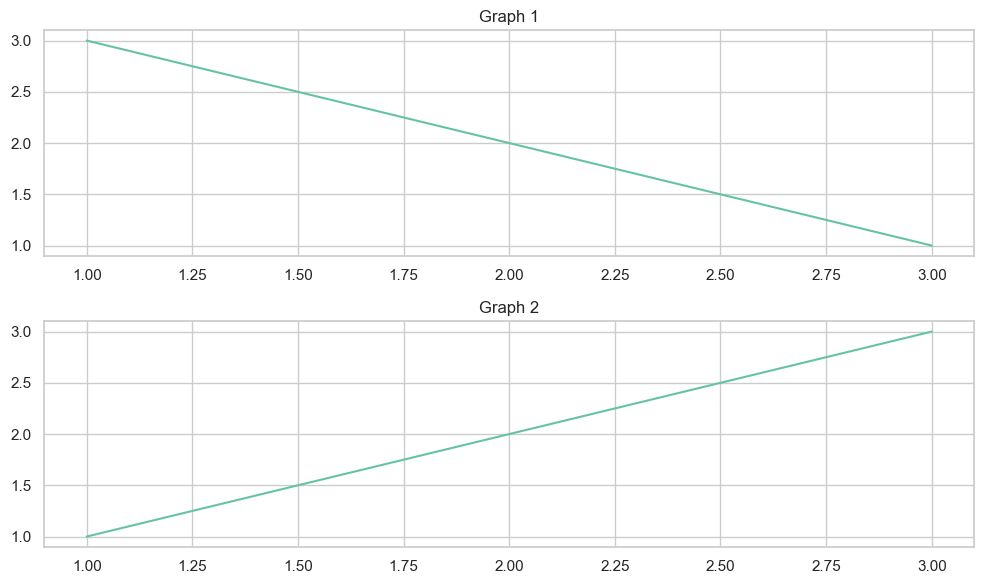

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot([1, 2, 3], [3, 2, 1])
axs[0].set_title("Graph 1")

axs[1].plot([1, 2, 3], [1, 2, 3])
axs[1].set_title("Graph 2")

plt.tight_layout()
plt.show()


#### Correlation matrix

            Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL
Close_AAPL    1.000000   0.999396  0.999392   0.998656
High_AAPL     0.999396   1.000000  0.999256   0.999398
Low_AAPL      0.999392   0.999256  1.000000   0.999399
Open_AAPL     0.998656   0.999398  0.999399   1.000000


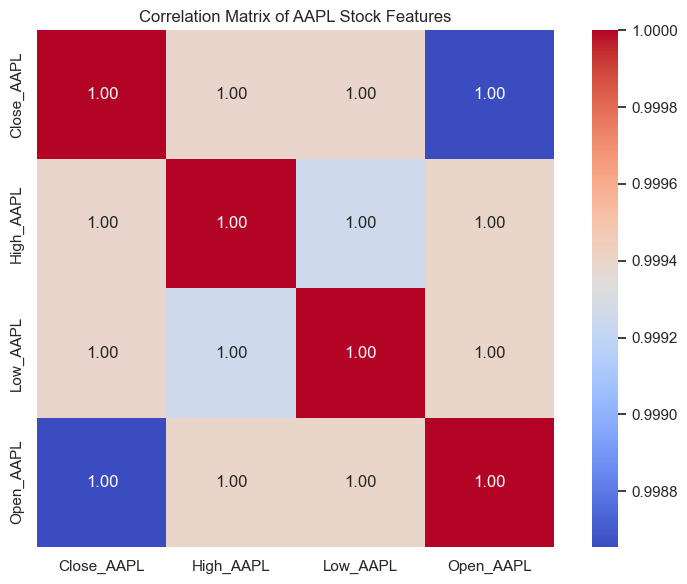

In [11]:
# Compute and plot the correlation matrix for the features
corr_matrix = df_for_sns[features_for_sns].corr()

print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of AAPL Stock Features')
plt.tight_layout()
plt.show()

we understand that the correlation between the features is very high, thanks to the fact that they are all related to the same stock. This means that we need to be careful when training our model, as it may lead to overfitting.

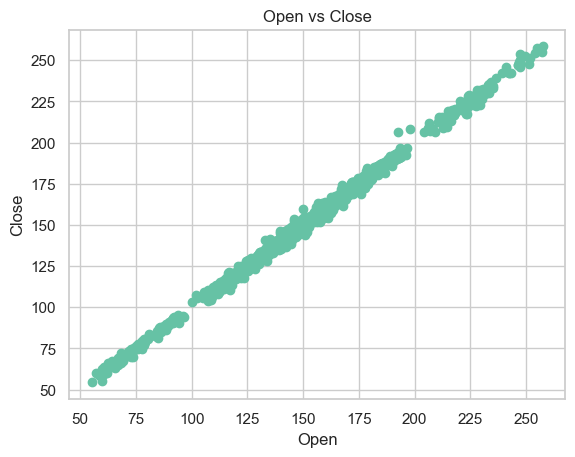

In [12]:
plt.scatter(df['Open'], df['Close'])
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('Open vs Close')
plt.show()

#### Daily returns

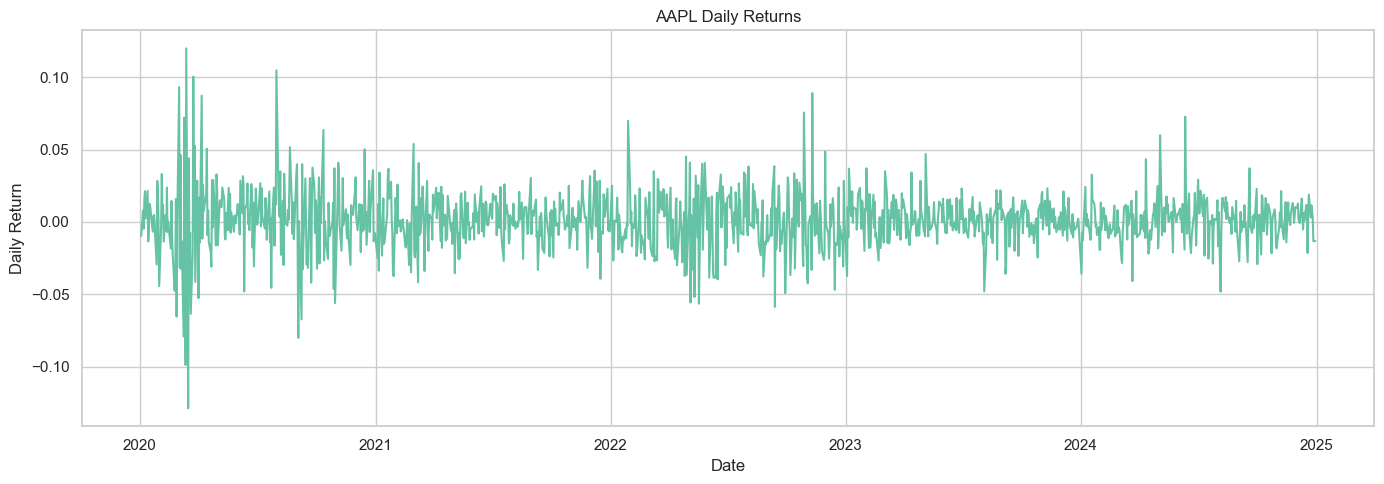

In [13]:
df['Daily_Return'] = df[('Close', 'AAPL')].pct_change()

df['Daily_Return'].describe()

plt.figure(figsize=(14,5))
plt.plot(df.index, df['Daily_Return'])
plt.title('AAPL Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Box plot of price distribution

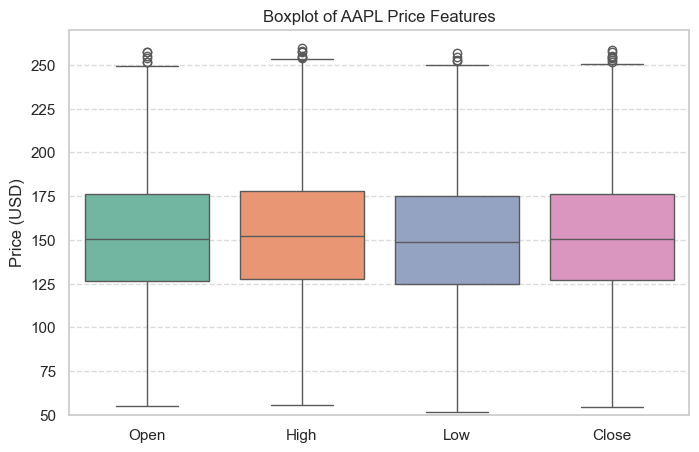

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']], palette='Set2')
plt.title('Boxplot of AAPL Price Features')
plt.ylabel('Price (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(50, 270)
plt.show()

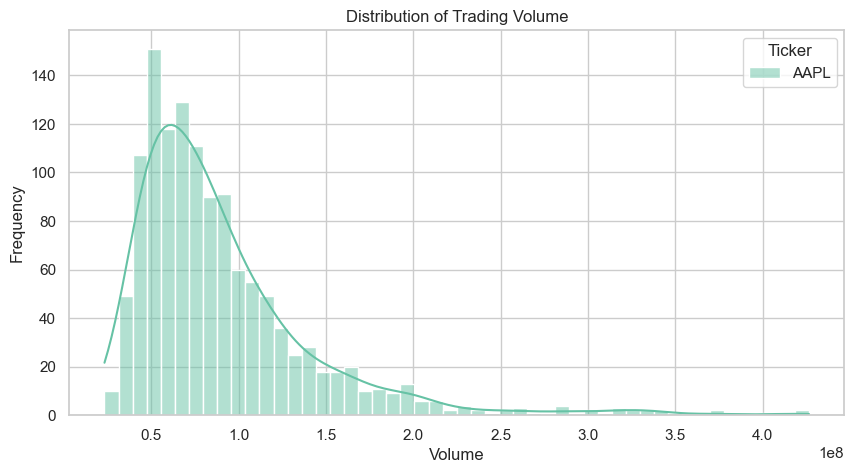

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Volume'], bins=50, kde=True)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

In [16]:
threshold = df['Volume'].quantile(0.99)
high_volume_days = df[df['Volume'] > threshold]
print("Number of high-volume days:", len(high_volume_days))

Number of high-volume days: 1257


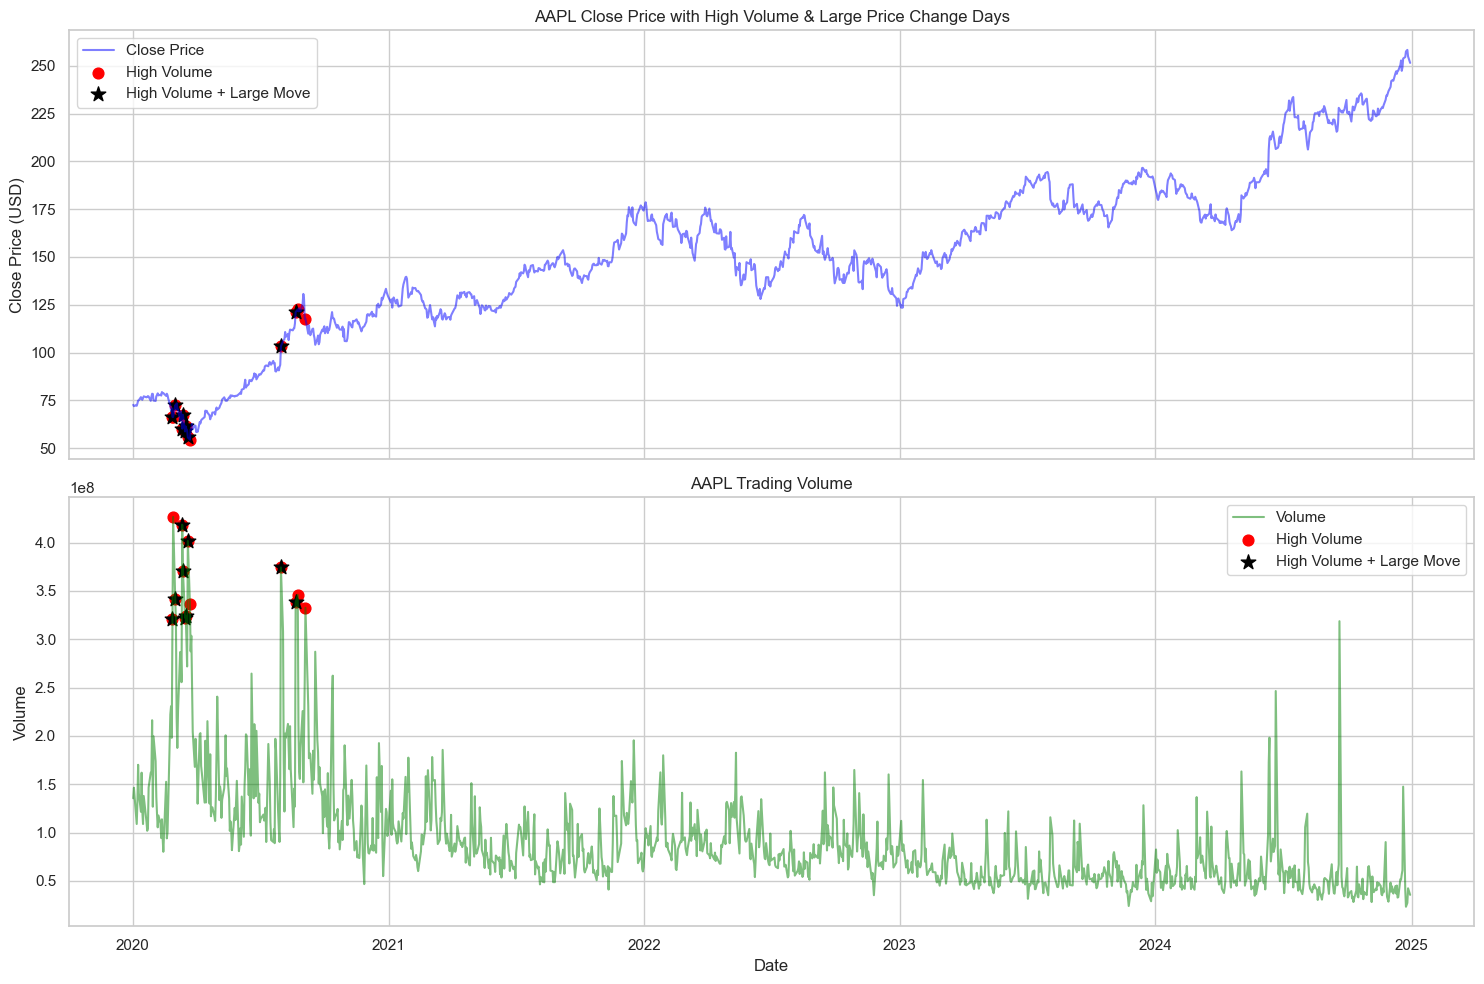

In [17]:
# flatten col names
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]

df['Daily_Return'] = df['Close_AAPL'].pct_change()

# unusuals volume days
volume_threshold = df['Volume_AAPL'].quantile(0.99)
ret_std = df['Daily_Return'].std()
ret_mean = df['Daily_Return'].mean()


high_volume_days = df[df['Volume_AAPL'] > volume_threshold]

large_move_days = df[abs(df['Daily_Return'] - ret_mean) > 2 * ret_std]

special_days = df[(df['Volume_AAPL'] > volume_threshold) & (abs(df['Daily_Return'] - ret_mean) > 2 * ret_std)]

# plotting
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axes[0].plot(df.index, df['Close_AAPL'], label='Close Price', color='blue', alpha=0.5)
axes[0].scatter(high_volume_days.index, high_volume_days['Close_AAPL'], color='red', label='High Volume', marker='o', s=60)
axes[0].scatter(special_days.index, special_days['Close_AAPL'], color='black', label='High Volume + Large Move', marker='*', s=120)
axes[0].set_ylabel('Close Price (USD)')
axes[0].set_title('AAPL Close Price with High Volume & Large Price Change Days')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df.index, df['Volume_AAPL'], label='Volume', color='green', alpha=0.5)
axes[1].scatter(high_volume_days.index, high_volume_days['Volume_AAPL'], color='red', label='High Volume', marker='o', s=60)
axes[1].scatter(special_days.index, special_days['Volume_AAPL'], color='black', label='High Volume + Large Move', marker='*', s=120)
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].set_title('AAPL Trading Volume')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### rolling mean

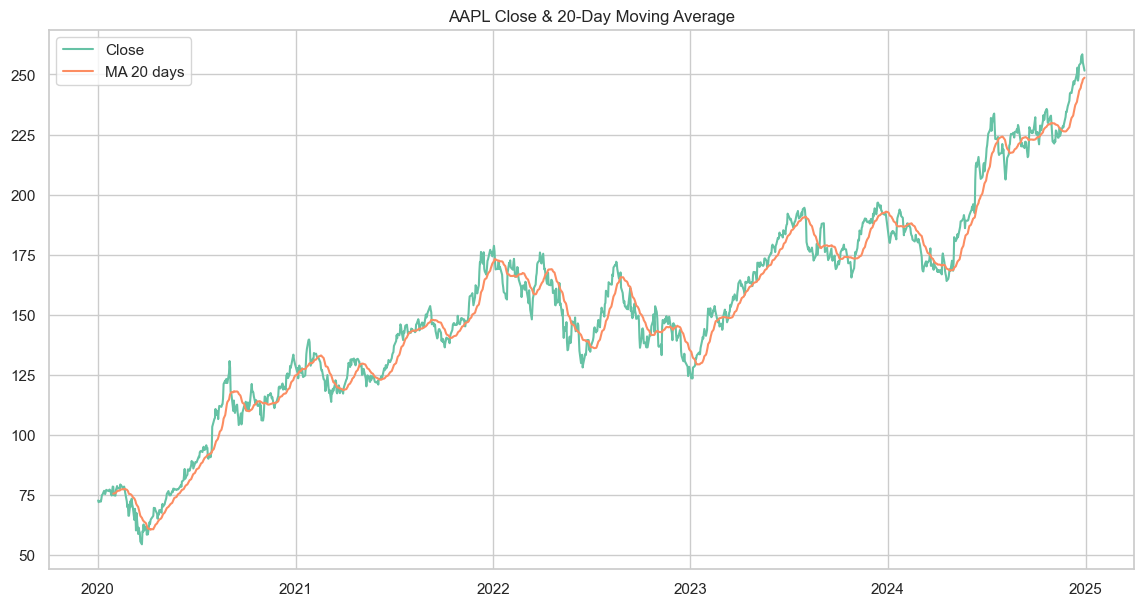

In [18]:
df['MA20'] = df[('Close_AAPL')].rolling(window=20).mean()
plt.figure(figsize=(14,7))
plt.plot(df.index, df[('Close_AAPL')], label='Close')
plt.plot(df.index, df['MA20'], label='MA 20 days')
plt.legend()
plt.title('AAPL Close & 20-Day Moving Average')
plt.show()

### 2. Data Preprocessing


## Inflation Adjustment: Converting Stock Prices to Current Dollars

To enable accurate comparison of AAPL price data over multiple years and eliminate the effect of inflation, all price columns are adjusted to current U.S. dollars using the Consumer Price Index (CPI) from the Federal Reserve Economic Data (FRED). This adjustment ensures that long-term trends reflect real (inflation-adjusted) price changes, not just nominal increases.

In [19]:
# TODO

#### seasonal decomposition

In [20]:
df['Year'] = df.index.year
df['DayOfWeek'] = df.index.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['DayOfWeek'] = df['DayOfWeek'].map(dict(enumerate(day_names)))
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_names,ordered=True)
print(df['DayOfWeek'].unique())
df['Month'] = df.index.month
month_names = list(calendar.month_name)[1:] # ['January', ..., 'December']
df['Month'] = df['Month'].map(dict(zip(range(1, 13), month_names)))
df['Month'] = pd.Categorical(df['Month'], categories=month_names, ordered=True)
print(df['Month'].unique())

['Thursday', 'Friday', 'Monday', 'Tuesday', 'Wednesday']
Categories (5, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday']
['January', 'February', 'March', 'April', 'May', ..., 'August', 'September', 'October', 'November', 'December']
Length: 12
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']


##### seasonality by month

/var/folders/x0/x2vffgpn4mv88fvwb47hvlmc0000gn/T/ipykernel_5923/4200205056.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg = df.groupby('Month')['Daily_Return'].mean()


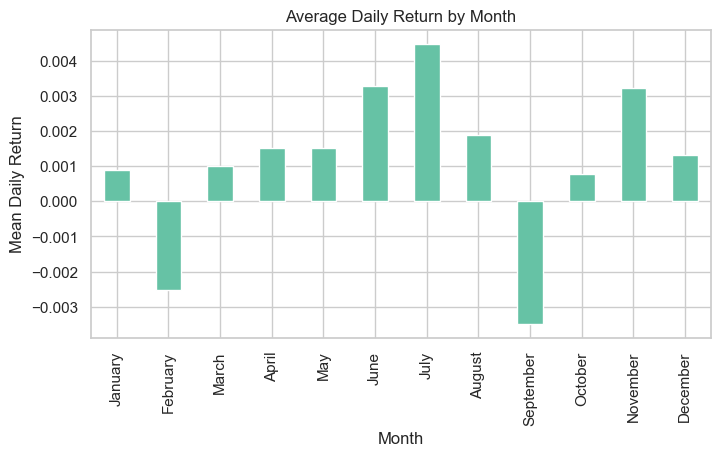

In [21]:
monthly_avg = df.groupby('Month')['Daily_Return'].mean()

plt.figure(figsize=(8, 4))
monthly_avg.plot(kind='bar')
plt.title('Average Daily Return by Month')
plt.ylabel('Mean Daily Return')
plt.xlabel('Month')
plt.grid(True)
plt.show()

/var/folders/x0/x2vffgpn4mv88fvwb47hvlmc0000gn/T/ipykernel_5923/243346374.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg = df.groupby('Month')['Volume_AAPL'].mean()


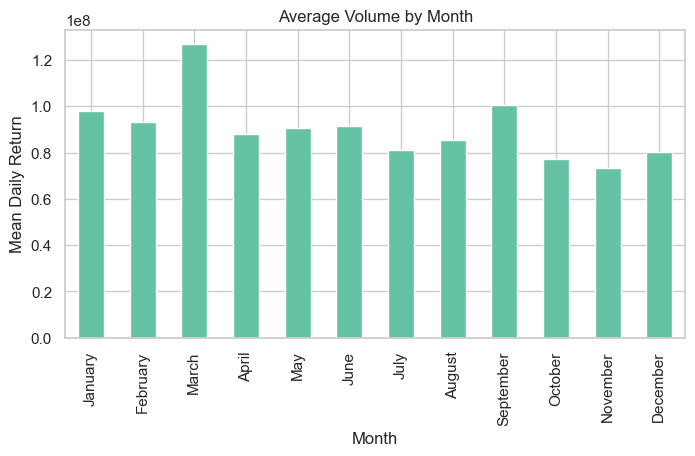

In [22]:
monthly_avg = df.groupby('Month')['Volume_AAPL'].mean()

plt.figure(figsize=(8, 4))
monthly_avg.plot(kind='bar')
plt.title('Average Volume by Month')
plt.ylabel('Mean Daily Return')
plt.xlabel('Month')
plt.grid(True)
plt.show()

#### seasonality by day of week

/var/folders/x0/x2vffgpn4mv88fvwb47hvlmc0000gn/T/ipykernel_5923/1238027972.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dow_avg = df.groupby('DayOfWeek')['Daily_Return'].mean().reindex(day_names)


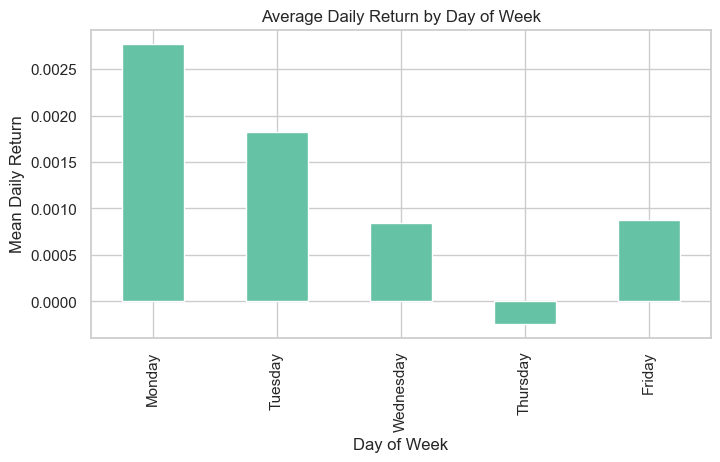

In [23]:
dow_avg = df.groupby('DayOfWeek')['Daily_Return'].mean().reindex(day_names)
plt.figure(figsize=(8, 4))
dow_avg.plot(kind='bar')
plt.title('Average Daily Return by Day of Week')
plt.ylabel('Mean Daily Return')
plt.xlabel('Day of Week')
plt.grid(True)
plt.show()

/var/folders/x0/x2vffgpn4mv88fvwb47hvlmc0000gn/T/ipykernel_5923/1877633182.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dow_avg = df.groupby('DayOfWeek')['Volume_AAPL'].mean().reindex(day_names)


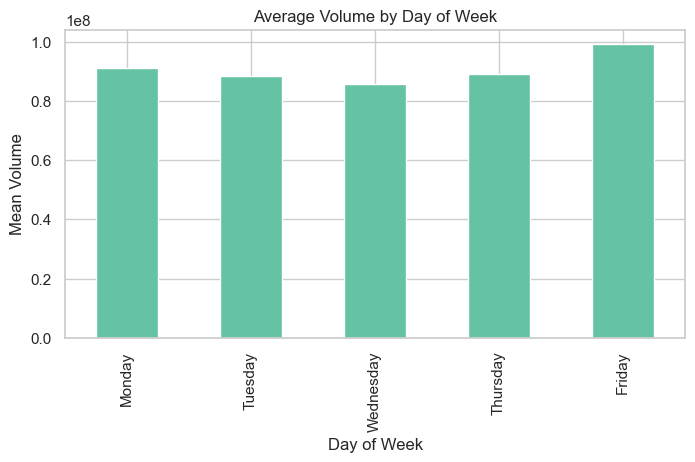

In [24]:
dow_avg = df.groupby('DayOfWeek')['Volume_AAPL'].mean().reindex(day_names)
plt.figure(figsize=(8, 4))
dow_avg.plot(kind='bar')
plt.title('Average Volume by Day of Week')
plt.ylabel('Mean Volume')
plt.xlabel('Day of Week')
plt.grid(True)
plt.show()

#### Mutual information

/Users/shakedschnarch/Documents/מסמכים מקומי/קריירה/פרויקט למידת מכונה/finyx-test/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shakedschnarch/Documents/מסמכים מקומי/קריירה/פרויקט למידת מכונה/finyx-test/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shakedschnarch/Documents/מסמכים מקומי/קריירה/פרויקט למידת מכונה/finyx-test/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True

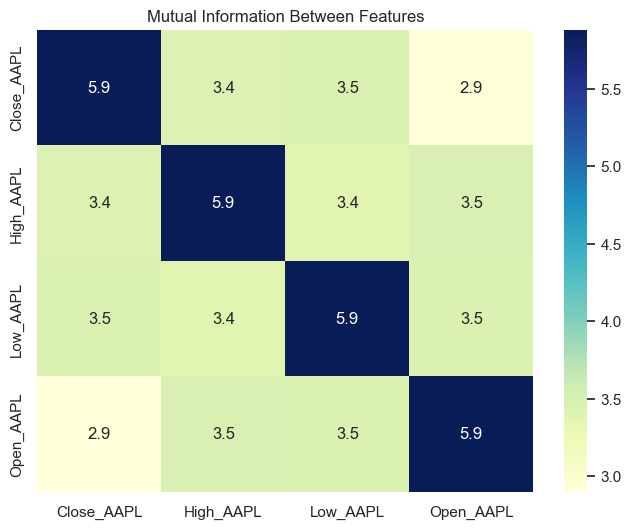

In [25]:
mi_matrix = pd.DataFrame(index= features_for_sns, columns=features_for_sns)

X = df_for_sns[features_for_sns]

for f1 in features_for_sns:
    for f2 in features_for_sns:
        mi_score = mutual_info_regression(X[[f1]], X[[f2]])
        mi_matrix.loc[f1, f2] = mi_score[0]

mi_matrix = mi_matrix.astype(float)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(mi_matrix, annot=True, cmap='YlGnBu')
plt.title('Mutual Information Between Features')
plt.show()

### 3. Feature Engineering


##### --- Feature Engineering Template ---

##### 1. Feature name: Daily_Return
    Description: predicts the percentage change in stock price from one day to the next, which can indicate momentum or reversal patterns.

In [26]:
# 1. Feature name: Daily_Return
df['Daily_Return'] = df['Close_AAPL'].pct_change()

# 2. Handle missing values created by rolling/shift (if any)
df['Daily_Return'] = df['Close_AAPL'].fillna(0)

# 3.Check that feature is ready for modeling
print(df['Daily_Return'].describe())
print("Any missing?", df['Daily_Return'].isnull().sum())

count    1257.000000
mean      151.900499
std        41.943932
min        54.378578
25%       126.750748
50%       150.537048
75%       176.443726
max       258.396667
Name: Daily_Return, dtype: float64
Any missing? 0


##### 2. Feature name: High_Low_Percent
    Description: measures the volatility of the stock by calculating the percentage difference between the high and low prices of each day, which can help identify potential price swings.

In [27]:
# 1. Featurw name: High_Low_Pct
df['High_Low_Pct'] = (df['High_AAPL'] - df['Low_AAPL']) / df['Open_AAPL']

# 2. Handle missing values created by rolling/shift (if any)
df['High_Low_Pct'] = df['High_Low_Pct'].fillna(0)

# 3.Check that feature is ready for modeling
print(df['High_Low_Pct'].describe())
print("Any missing?", df['High_Low_Pct'].isnull().sum())

count    1257.000000
mean        0.022457
std         0.012566
min         0.005404
25%         0.014274
50%         0.019061
75%         0.027472
max         0.106688
Name: High_Low_Pct, dtype: float64
Any missing? 0


##### 3. Feature name: Moving_Average
    Description: calculates the average stock price over a specified number of days, which can smooth out price fluctuations and highlight longer-term trends.

In [28]:
# Feature name: Moving_Average
df['MA20'] = df['Close_AAPL'].rolling(window=20).mean()

# 2. Handle missing values created by rolling/shift (if any)
df['MA20'] = df['MA20'].combine_first(df['Close_AAPL'].expanding().mean())

# 3. Check that feature is ready for modeling
print(df['MA20'].describe())
print("Any missing?", df['MA20'].isnull().sum())

count    1257.000000
mean      150.552194
std        41.312233
min        60.459790
25%       125.801200
50%       148.815124
75%       175.484522
max       248.668144
Name: MA20, dtype: float64
Any missing? 0


##### 4. Feature name: Relative_Volume
    Description: compares the current trading volume to the average volume over a specified period, which can indicate unusual trading activity or interest in the stock.

In [29]:
# Feature name: Volume_Change
df['Rel_Volume'] = df['Volume_AAPL'] / df['Volume_AAPL'].rolling(20).mean()

# 2. Handle missing values created by rolling/shift (if any)
df['Rel_Volume'] = df['Rel_Volume'].combine_first(df['Volume_AAPL'].expanding().mean())

# 3. Check that feature is ready for modeling
print(df['Rel_Volume'].describe())
print("Any missing?", df['Rel_Volume'].isnull().sum())

count    1.257000e+03
mean     2.013405e+06
std      1.626455e+07
min      4.085035e-01
25%      7.936592e-01
50%      9.244703e-01
75%      1.138437e+00
max      1.409016e+08
Name: Rel_Volume, dtype: float64
Any missing? 0


##### 5. Feature name: Quarter_Number
    This feature encodes the business quarter of each date (1=Q1, 2=Q2, 3=Q3, 4=Q4), regardless of the year.

In [30]:
# Ensure Month_Num is numeric month (1-12)
df['Month_Num'] = df.index.month

# Calculate Quarter_Number (1-4)
df['Quarter_Number'] = ((df['Month_Num'] - 1) // 3 + 1).astype(int)

# Check the feature
print(df['Quarter_Number'].describe())
print("Any missing?", df['Quarter_Number'].isnull().sum())
print("Unique values:", df['Quarter_Number'].unique())

count    1257.000000
mean        2.513126
std         1.115907
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Quarter_Number, dtype: float64
Any missing? 0
Unique values: [1 2 3 4]


#### 6. Feature name: Days_To_Quarter_End
    Description: calculates the number of days remaining until the end of the current business quarter, which can help identify potential price movements related to quarterly earnings reports or other events.

In [31]:
# Feature name: Days_To_Quarter_End
# Description: Counts the number of days from each date to the end of the business quarter (useful for modeling behavior around earnings reports, etc.)

# 1. Create feature: Days to end of quarter
quarter_end = df.index.to_period('Q').end_time
df['Days_To_Quarter_End'] = (quarter_end - df.index).days

# 2. Handle any missing values (should not happen, but just in case)
df['Days_To_Quarter_End'] = df['Days_To_Quarter_End'].fillna(-1).astype(int)

# 3. Check that feature is ready for modeling
print(df['Days_To_Quarter_End'].describe())
print("Any missing?", df['Days_To_Quarter_End'].isnull().sum())

count    1257.000000
mean       44.984089
std        26.207642
min         0.000000
25%        22.000000
50%        45.000000
75%        67.000000
max        91.000000
Name: Days_To_Quarter_End, dtype: float64
Any missing? 0


In [32]:
# Lag features (changes from previous days)
df['Close_Lag1'] = df['Close_AAPL'].shift(1)
df['Close_Lag2'] = df['Close_AAPL'].shift(2)
df['Return_Lag1'] = df['Daily_Return'].shift(1)
df['Return_Lag2'] = df['Daily_Return'].shift(2)
df['Return_Lag5'] = df['Daily_Return'].shift(5)

# Moving averages (use only past info!)
df['MA5'] = df['Close_AAPL'].shift(1).rolling(window=5).mean()
df['MA10'] = df['Close_AAPL'].shift(1).rolling(window=10).mean()
df['MA20'] = df['Close_AAPL'].shift(1).rolling(window=20).mean()

# Volatility features (rolling std of returns)
df['Volatility5'] = df['Daily_Return'].shift(1).rolling(window=5).std()
df['Volatility20'] = df['Daily_Return'].shift(1).rolling(window=20).std()

# Volume features (historical only)
df['Volume_Lag1'] = df['Volume_AAPL'].shift(1)
df['Volume_Lag5'] = df['Volume_AAPL'].shift(5)
df['Volume_MA5'] = df['Volume_AAPL'].shift(1).rolling(window=5).mean()
df['Rel_Volume'] = df['Volume_AAPL'] / df['Volume_AAPL'].shift(1).rolling(20).mean()

# High-Low spread (previous day)
df['High_Low_Pct_Lag1'] = ((df['High_AAPL'].shift(1) - df['Low_AAPL'].shift(1)) / df['Close_AAPL'].shift(1))

# Time features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# (Optional) Cumulative returns or rolling max/min of close
df['Rolling_Max10'] = df['Close_AAPL'].shift(1).rolling(10).max()
df['Rolling_Min10'] = df['Close_AAPL'].shift(1).rolling(10).min()

### One Hot Encoding for Categorical Features

In [33]:
# List of categorical features for one-hot encoding
categorical_features = ['DayOfWeek', 'Month', 'Quarter_Number']

# Apply one-hot encoding using pandas get_dummies
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Check the new columns
print("Columns after one-hot encoding:")
print(df.columns)

Columns after one-hot encoding:
Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'Daily_Return_', 'Daily_Return', 'MA20', 'Year', 'High_Low_Pct',
       'Rel_Volume', 'Month_Num', 'Days_To_Quarter_End', 'Close_Lag1',
       'Close_Lag2', 'Return_Lag1', 'Return_Lag2', 'Return_Lag5', 'MA5',
       'MA10', 'Volatility5', 'Volatility20', 'Volume_Lag1', 'Volume_Lag5',
       'Volume_MA5', 'High_Low_Pct_Lag1', 'Quarter', 'Rolling_Max10',
       'Rolling_Min10', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Quarter_Number_2', 'Quarter_Number_3', 'Quarter_Number_4'],
      dtype='object')


### Checking for missing values

In [34]:
print(df.isnull().sum())
# Optionally, fill NA (example: mean imputation for numeric columns)
df = df.fillna(df.mean(numeric_only=True))

Close_AAPL              0
High_AAPL               0
Low_AAPL                0
Open_AAPL               0
Volume_AAPL             0
Daily_Return_           1
Daily_Return            0
MA20                   20
Year                    0
High_Low_Pct            0
Rel_Volume             20
Month_Num               0
Days_To_Quarter_End     0
Close_Lag1              1
Close_Lag2              2
Return_Lag1             1
Return_Lag2             2
Return_Lag5             5
MA5                     5
MA10                   10
Volatility5             5
Volatility20           20
Volume_Lag1             1
Volume_Lag5             5
Volume_MA5              5
High_Low_Pct_Lag1       1
Quarter                 0
Rolling_Max10          10
Rolling_Min10          10
DayOfWeek_1             0
DayOfWeek_2             0
DayOfWeek_3             0
DayOfWeek_4             0
Month_2                 0
Month_3                 0
Month_4                 0
Month_5                 0
Month_6                 0
Month_7     

### Outliers detection and removal

In [35]:
# Clip extreme values in 'Daily_Return' to the 1st and 99th percentiles
df['Daily_Return'] = df['Daily_Return'].clip(lower=df['Daily_Return'].quantile(0.01),
                                             upper=df['Daily_Return'].quantile(0.99))

#### Numerical Features Scaling

In [36]:
numeric_features = ['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL', 'Volume_AAPL', 'High_Low_Pct', 'Rel_Volume']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

#### Drop unnecessary columns

In [37]:
# --- Choose features to keep ---
features_to_keep = [
    'High_Low_Pct',
    'Rel_Volume',
    'Days_To_Quarter_End',
    'Quarter', 
    'Volume_Lag1'
            ]

# Create your final X
X = df[features_to_keep].copy()

# Ensure no missing values in X
X = X.fillna(0)

# indexing
X.index = df.index

print("Selected features:", X.columns.tolist())
print("Shape:", X.shape)

Selected features: ['High_Low_Pct', 'Rel_Volume', 'Days_To_Quarter_End', 'Quarter', 'Volume_Lag1']
Shape: (1257, 5)


### Features and Target Variable Selection

In [38]:
print("Features shape:", X.shape)
print("Features columns:", X.columns)


y = df['Daily_Return']
print("Target shape:", df['Daily_Return'].shape)


Features shape: (1257, 5)
Features columns: Index(['High_Low_Pct', 'Rel_Volume', 'Days_To_Quarter_End', 'Quarter',
       'Volume_Lag1'],
      dtype='object')
Target shape: (1257,)


### 4. Train/Test Split


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False preserves time order for time series!
)

#### Indexing the DataFrame

In [40]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Dimention checking

In [41]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1005, 5) (252, 5) (1005,) (252,)


### 5. Model Training


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 4. Evaluation function
def print_scores(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R^2: {r2_score(y_true, y_pred):.4f}")

# 5. Print scores for all models
print_scores(y_test, y_pred_lr, "Linear Regression")
print_scores(y_test, y_pred_rf, "Random Forest")
print_scores(y_test, y_pred_xgb, "XGBoost")


Model: Linear Regression
MAE: 50.2622
MSE: 3041.6834
R^2: -3.8669

Model: Random Forest
MAE: 44.1138
MSE: 2466.5168
R^2: -2.9466

Model: XGBoost
MAE: 45.6966
MSE: 2707.1419
R^2: -3.3316


### Feature Importance

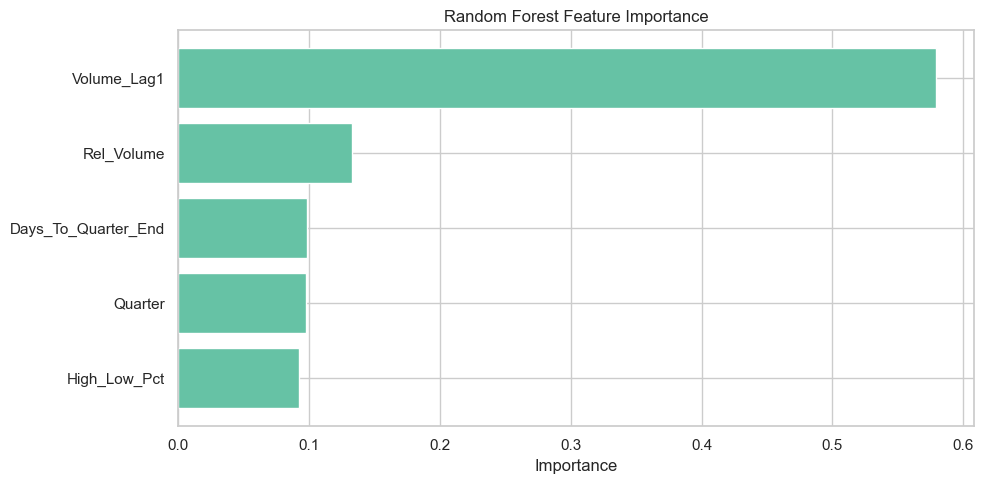

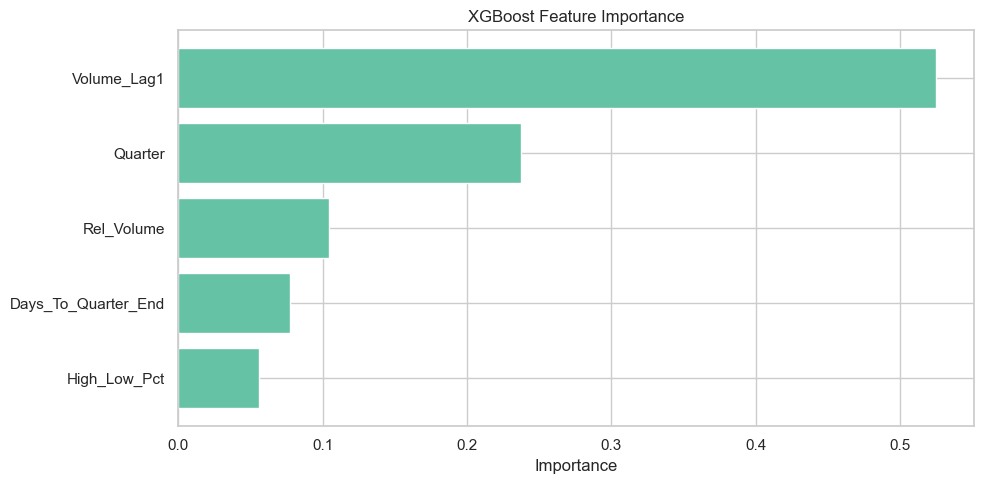

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# --- Random Forest Feature Importance ---
plt.figure(figsize=(10, 5))
indices = np.argsort(rf.feature_importances_)
plt.barh(range(len(indices)), rf.feature_importances_[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# --- XGBoost Feature Importance ---
plt.figure(figsize=(10, 5))
indices = np.argsort(xgb.feature_importances_)
plt.barh(range(len(indices)), xgb.feature_importances_[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Residual Analysis

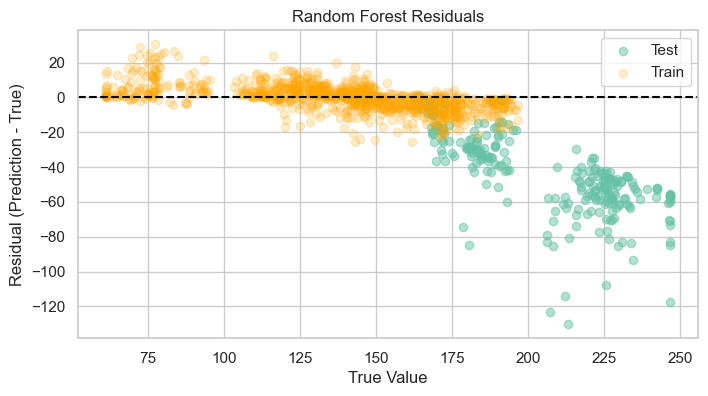

In [44]:
# Choose a model, e.g., Random Forest
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

plt.figure(figsize=(8,4))
plt.scatter(y_test, y_pred_rf - y_test, alpha=0.5, label='Test')
plt.scatter(y_train, y_pred_train_rf - y_train, alpha=0.2, label='Train', color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('True Value')
plt.ylabel('Residual (Prediction - True)')
plt.title('Random Forest Residuals')
plt.legend()
plt.show()

### Overfitting/Underfitting check

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_scores(y_true, y_pred, set_name=""):
    print(f"{set_name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{set_name} MSE:  {mean_squared_error(y_true, y_pred):.4f}")
    print(f"{set_name} R2:   {r2_score(y_true, y_pred):.4f}")
    print("")

print("Random Forest — Train:")
print_scores(y_train, y_pred_train_rf, set_name="Train")
print("Random Forest — Test:")
print_scores(y_test, y_pred_rf, set_name="Test")

Random Forest — Train:
Train MAE:  5.5833
Train MSE:  58.6114
Train R2:   0.9473

Random Forest — Test:
Test MAE:  44.1138
Test MSE:  2466.5168
Test R2:   -2.9466



### cross-validation

In [46]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
rf_scores = cross_val_score(rf, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print("Random Forest TimeSeries CV MAE (mean):", -np.mean(rf_scores))

Random Forest TimeSeries CV MAE (mean): 34.313078677876305


Random Forest with PCA features:
MAE: 44.0724
MSE: 2444.5117
R^2: -2.9113


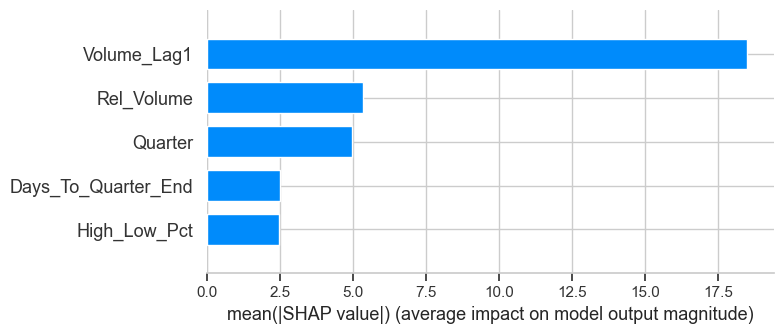

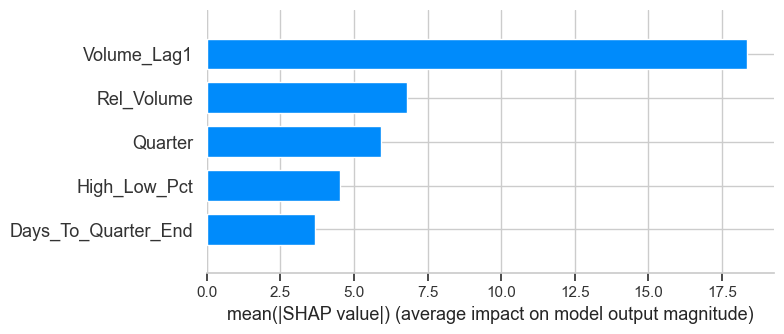

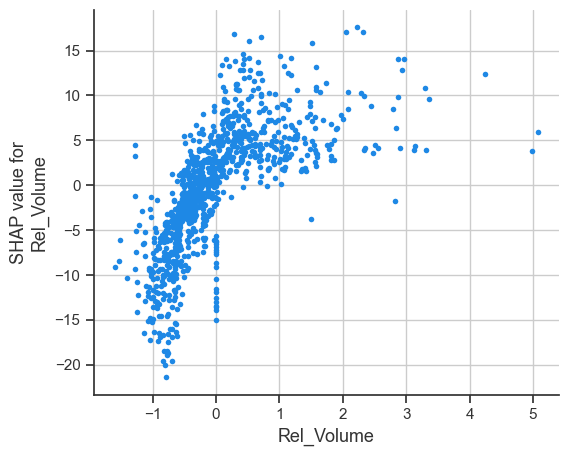

In [47]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fit PCA on training data and transform both train and test
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Random Forest on PCA features
rf_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_test_pca)

# Evaluate
print("Random Forest with PCA features:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf_pca):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_pca):.4f}")
print(f"R^2: {r2_score(y_test, y_pred_rf_pca):.4f}")

# SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_train)

# SHAP summary plot for Random Forest
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

# SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)

# SHAP summary plot for XGBoost
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

# SHAP dependence plot for a specific feature (e.g., 'Rel_Volume')
feature_name = 'Rel_Volume'
shap.dependence_plot(feature_name, shap_values_rf, X_train, interaction_index=None)

### 7. Feature Importance & Explainability


### 8. Discussion & Next Steps
